In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
words = open('_inputs/names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

## **Bigram Model**
The bigram model just looks at the previous character to predict the next one

In [4]:
b = {} # bigram dictionary to store the couples of characters and relative counts
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [5]:
# printing the top 5 most frequent bigrams in the dictionary
sorted(b.items(), key=lambda x: x[1], reverse=True)[:5]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983)]

In [6]:
N = torch.zeros((27,27) , dtype=torch.int32)

In [7]:
chars = sorted(list(set(''.join(words)))) # list of all the unique characters in the dataset
stoi = {s:i+1 for i,s in enumerate(chars)} # dictionary to convert characters to integers
stoi['.'] = 0

In [8]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        N[stoi[ch1], stoi[ch2]] += 1

In [9]:
itos = {i:s for s,i in stoi.items()} # inverse dictionary to convert integers to characters just for the plot

(-0.5, 26.5, 26.5, -0.5)

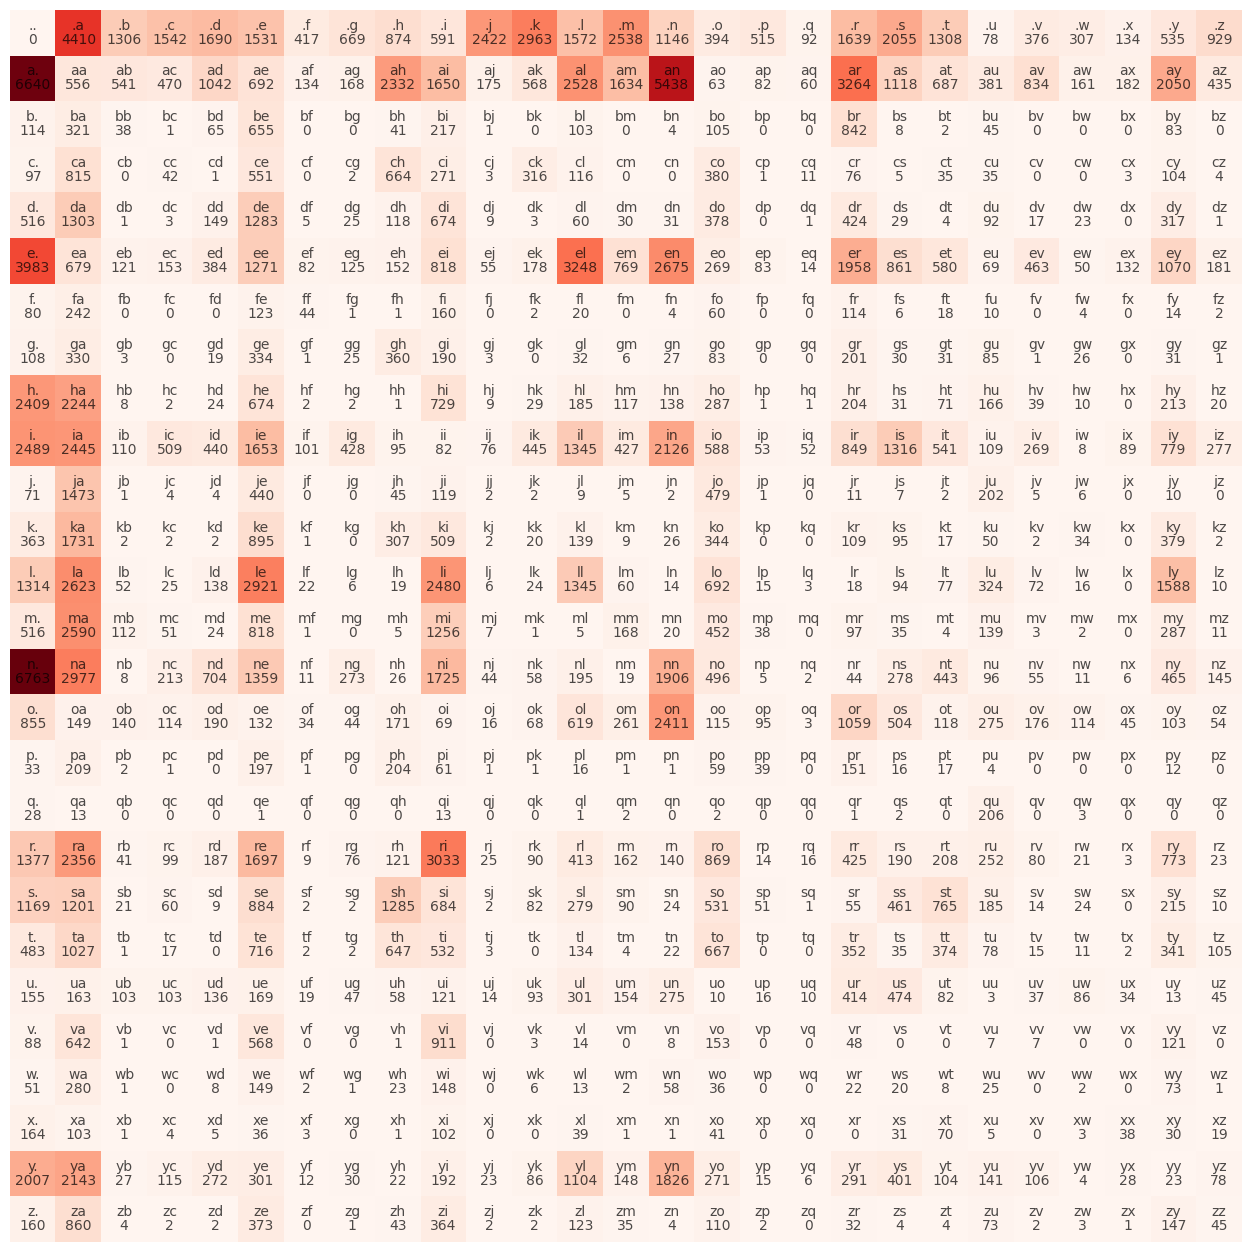

In [10]:
plt.figure(figsize=(16,16))

plt.imshow(N, cmap='Reds')
for i in range (27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='black', alpha=0.7)
        plt.text(j, i, N[i,j].item(), ha='center', va='top', color='black', alpha=0.7)
plt.axis('off')

In [11]:
p = N[0,:].float() # taking the first row of the matrix
p = p / p.sum()
p # probability of each character to be the first character of a word

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [12]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
print(ix)
itos[ix]

10


'j'

### **We are Learning what broadcasting is and why it is super important to understand**
- Here the idea is that I can do the operation of P / P.sum(etc...) because pytorch actually takes the column of values representing the sum of each row and makes it become a 27 x 27 matrix of identical values. Then it divides each value i,j by the i,j of the sum.
- This operation is internally managed by pytorch and the reason for its allowance is that the operation is broadcastable

In [13]:
P = (N+1).float()
P /= P.sum(dim=1, keepdim=True) # Divinding each value by the sum of the row in which the value is

In [14]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(15):
    out = []
    ix = 0
    while True:
        p = P[ix,:]
        ix = torch.multinomial(p, 1, replacement=True, generator=g).item()
        if ix == 0:
            break
        out.append(itos[ix])
    print(''.join(out))

junide
janasah
p
cony
a
nn
kohin
tolian
juee
ksahnaauranilevias
dedainrwieta
ssonielylarte
faveumerifontume
phynslenaruani
core


### **Now we want to evaluate the quality of this model**

In [15]:
log_likelihood = 0
n = 0

for w in ['andrejq']:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'Log-likelihood: {log_likelihood:.4f}')
nll = -log_likelihood
print(f'Negative Log-likelihood: {nll:.4f}')
print(f'Average Negative Log-likelihood: {nll/n:.4f}')

.a: 0.1376 -1.9835
an: 0.1604 -1.8302
nd: 0.0384 -3.2594
dr: 0.0770 -2.5646
re: 0.1334 -2.0143
ej: 0.0027 -5.9004
jq: 0.0003 -7.9817
q.: 0.0970 -2.3331
Log-likelihood: -27.8672
Negative Log-likelihood: 27.8672
Average Negative Log-likelihood: 3.4834


### **New Approach (using NN framework)**
We will end up with a very similar output but actually framing the problem with a more neural network framwork

In [16]:
# create the traning set of all the bigrams
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

# here there is the difference between .tensor and .Tensor which is: .t makes an integer dtype while .T makes a float dtype
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [17]:
xs

tensor([ 0,  5, 13, 13,  1])

In [18]:
ys

tensor([ 5, 13, 13,  1,  0])

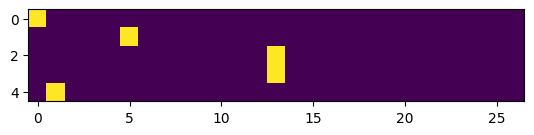

In [19]:
# because giving to the neural network a single integer is not enough, we need to convert it to a one-hot encoding
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float() # here we are converting the input integers to one-hot encoding with 27 classes
yenc = F.one_hot(ys, num_classes=27).float() # here we are converting the output integers to one-hot encoding with 27 classes
plt.imshow(xenc)

In [20]:
# Now I want to create the initial weights for the neural network
W = torch.randn((27, 27)) # creating the simple neural net with 27 weights (first 27) and 27 neurons (second 27)
xenc @ W # (5, 27) @ (27, 27) = (5 x 27) - for instance due to the first input having 5 letters (.emma)

tensor([[-0.0497, -0.2351,  2.0681, -1.6402, -0.2652, -0.5652, -0.4201, -0.4869,
          1.3322,  1.5844,  0.3775,  0.1251, -0.4099,  0.4508,  0.2934,  0.1675,
         -0.8905, -0.2456, -0.4771, -0.7646,  0.6021, -0.7614,  2.2906,  1.7696,
         -0.5633, -0.2764,  0.0422],
        [ 0.0438, -0.5153,  0.4620, -1.2728, -0.8009, -1.3210,  1.0201, -0.0264,
          0.1501, -0.7600,  2.0062,  1.5691, -1.4356,  0.0741, -0.5325,  0.6417,
          1.1370,  1.2030, -0.1946, -0.2002,  0.5126,  1.9064,  0.9604,  0.6745,
         -0.2867,  0.1411,  1.7217],
        [-0.5111, -0.8701,  1.6581,  0.9845, -0.4334,  1.4672, -0.4203,  1.1301,
          0.3828, -0.6863,  0.1364, -0.6204, -0.6885,  1.7733,  1.7744, -1.4592,
         -0.1703,  2.0158,  1.9468,  0.0237,  0.8476,  0.8653, -0.5885, -0.2675,
          0.7387, -0.6884,  0.1736],
        [-0.5111, -0.8701,  1.6581,  0.9845, -0.4334,  1.4672, -0.4203,  1.1301,
          0.3828, -0.6863,  0.1364, -0.6204, -0.6885,  1.7733,  1.7744, -1.4592

In [21]:
# but we are interensting in positive numbers so the need to exponentiate the result
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
probs

tensor([[0.0186, 0.0155, 0.1546, 0.0038, 0.0150, 0.0111, 0.0128, 0.0120, 0.0741,
         0.0953, 0.0285, 0.0222, 0.0130, 0.0307, 0.0262, 0.0231, 0.0080, 0.0153,
         0.0121, 0.0091, 0.0357, 0.0091, 0.1931, 0.1147, 0.0111, 0.0148, 0.0204],
        [0.0193, 0.0110, 0.0293, 0.0052, 0.0083, 0.0049, 0.0512, 0.0180, 0.0214,
         0.0086, 0.1372, 0.0886, 0.0044, 0.0199, 0.0108, 0.0351, 0.0575, 0.0614,
         0.0152, 0.0151, 0.0308, 0.1242, 0.0482, 0.0362, 0.0139, 0.0212, 0.1032],
        [0.0100, 0.0070, 0.0874, 0.0446, 0.0108, 0.0722, 0.0109, 0.0516, 0.0244,
         0.0084, 0.0191, 0.0090, 0.0084, 0.0981, 0.0982, 0.0039, 0.0140, 0.1250,
         0.1167, 0.0171, 0.0389, 0.0396, 0.0092, 0.0127, 0.0349, 0.0084, 0.0198],
        [0.0100, 0.0070, 0.0874, 0.0446, 0.0108, 0.0722, 0.0109, 0.0516, 0.0244,
         0.0084, 0.0191, 0.0090, 0.0084, 0.0981, 0.0982, 0.0039, 0.0140, 0.1250,
         0.1167, 0.0171, 0.0389, 0.0396, 0.0092, 0.0127, 0.0349, 0.0084, 0.0198],
        [0.0799, 0.0023,

### **Building the Neural Network**

In [22]:
# randomply initializing 27 neruons weights. Each neuron receives 27 weights.
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [23]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # one-hot encoding of the input
logits = xenc @ W # predict log-counts
counts = logits.exp() # convert to counts
probs = counts / counts.sum(dim=1, keepdim=True) # probabilities of the next character
loss = -probs[torch.arange(5), ys].log().mean() # negative log-likelihood

In [24]:
print(loss.item())

3.7693049907684326


In [25]:
# backward pass
W.grad = None # set the initail gradient to zero
loss.backward()

In [26]:
W.data += -0.1 * W.grad # update the weights (updating the tensor data)

## **Actually running the neural network**

In [27]:
# creating the dataset
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('num of examples: ', num)

# initialize the network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

num of examples:  228146


In [28]:
# gradient descent
xenc = F.one_hot(xs, num_classes=27).float()

for k in range(100):
    # forward pass
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01 * (W**2).mean()
    print('Average Loss at step', k, ':', loss.item(), end='\r')
    
    W.grad = None
    loss.backward()

    W.data += -20 * W.grad

In [29]:
W.shape

torch.Size([27, 27])

In [30]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(15):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdim=True)
        ix = torch.multinomial(probs.view(-1), 1, replacement=True, generator=g).item()
        if ix == 0:
            break
        out.append(itos[ix])
    print(''.join(out))

junide
janasah
pxzfay
a
nn
kai
ritolian
jgee
ksaheiauyanilevias
dbdainrwieta
sejaielylarte
favmumerifontume
pfynslenariani
core
yaenon
